# Project 2: Spam/Ham Prediction

In this project, you will use what you've learned in class to create a classifier that can distinguish spam emails from ham (non-spam) emails.

We'll walk you through a couple steps to get you started, but this project is almost entirely open-ended. Instead of providing you with a skeleton to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

## Kaggle

This project is a bit different from the other assignments in this class because we are using Kaggle to evaluate your model's accuracy. Kaggle is a website that hosts machine learning competitions.

We've created a competition just for this project: https://www.kaggle.com/t/433a6bca95f94a78a0d2a6e7e8b311c3

Here's how submitting to Kaggle works:

1. You will create a classifier using the training dataset.
2. You will use your classifier to make predictions on the test dataset.
3. You will upload your predictions as a CSV to https://www.kaggle.com/t/433a6bca95f94a78a0d2a6e7e8b311c3
4. The website will tell you your accuracy on the test set. You may only do this twice a day. You must reach a test set accuracy of **88%** in order to get full credit for the Kaggle portion of the assignment.

(After the assignment ends, we will evaluate your accuracy on a private test set to ensure that you aren't overfitting to the test set.)

## Submission

This project has no ok tests (and no autograder). Instead, you will submit the following:

0. **Your notebook to OkPy**. You can do this by running the `ok.submit()` cell at the bottom of this notebook. Note that there is no autograder for this assignment so you will not receive autograder emails.
0. **Your notebook's written answers to GradeScope.** The cell to export the notebook is located at the bottom of this notebook. If you have trouble converting your notebook to PDF, you may upload your notebook to http://datahub.berkeley.edu/ and run the cell there.
0. **Your model's predictions on the test set to Kaggle**, a website that hosts machine learning competitions. Kaggle will output your your accuracy on the test set so that you will know whether you've met the accuracy threshold or not.

**To prevent you from fitting to the test set, you may only upload predictions to Kaggle twice per day.** This means you should start early. In addition, if you decide to pair with someone else, your group only gets two submissions per day (not four).

This project (notebook + Gradescope submissions) is officially due Friday, Dec 1 at 11:59:59pm since we can't make assignments due after classes end. However, we will accept submissions until **Monday, Dec 4 at 11:59:59pm** without using slip days. Submissions after Dec 4 will use 1 slip day each day after Dec 4. The Kaggle competition will remain open until **Saturday Dec 9 at 11:59:59pm**.

**No late Kaggle submissions will be accepted** since we've taken slip days into account when setting the Kaggle deadline. You will not use slip days for Kaggle submissions.

## Grading
Grading will be based on a number of set criteria, enumerated below:

Task | Description
--- | ---
Basic Classifier | You succesfully implement our guided basic logistic regression classifier.
EDA | You create four exploratory plots that help explain your feature choices.
Feature Selection | You explain and justify your feature selection process
Written Questions | You answer the written questions that we place throughout this notebook.
Kaggle Accuracy | Your model beats the prediction accuracy threshold of **88%**. This is attainable with a well-thought-out model.

**You are allowed to work in groups of 2 for this assignment!** If you decide to partner with someone else, make sure you do the following:

1. Have one person in the group invite the other on OkPy: https://okpy.org/cal/ds100/fa17/proj2/
1. Have one person in the group invite the other person on Gradescope.
1. Have one person in the group invite the other person on Kaggle: https://www.kaggle.com/t/433a6bca95f94a78a0d2a6e7e8b311c3

## Prizes

Although you need to reach 88% accuracy in order to get full credit, we will reward those that create great classifiers.

The top 10 students on the Kaggle leaderboard, evaluated by their score in the private test set will: 

1. Have bragging rights 
2. Be invited to attend a lunch at the Faculty Club, hosted by Professors Gonzalez and Nolan.

## Restrictions

While we want you to be creative with your models, we want to make it fair to students who are seeing these techniques for the first time.  As such, **you are only allowed to train logistic regression models and their regularized forms**.  This means no random forest, CART, neural nets, etc.  However, you are free to feature engineer to your heart's content.  Remember that domain knowledge is the third component of data science.

## Getting Started

In [243]:
# Run this cell to set up your notebook
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib inline
sns.set()
sns.set_context("talk")

from IPython.display import display, Latex, Markdown, HTML, Javascript
from client.api.notebook import Notebook
ok = Notebook('proj2.ok')

Assignment: Project 2
OK, version v1.13.9



In [3]:
# Log into OkPy.
# You might need to change this to ok.auth(force=True) if you get an error
ok.auth(force=False)

Successfully logged in as sungbin.andy.kang@berkeley.edu


For your convenience, run this cell to highlight the written response cells in light blue. Only the highlighted cells will be converted to the GradeScope PDF, so put your written answers there.

Unfortunately, you'll have to run this each time you open your notebook to highlight cells.

In [4]:
highlight_cells = '''
Jupyter.notebook.get_cells().map(function(cell) {
  var tags = cell.metadata.tags
  if (tags && tags.indexOf('written') >= 0)
    cell.element.css('background-color', '#efefff')
})
'''
display(Javascript(highlight_cells))

<IPython.core.display.Javascript object>

## Loading in the Data

The dataset consists of email messages and their labels (0 for ham, 1 for spam). The training set contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains three columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email
1. `email`: The text of the email.
1. `spam`: 1 if the email was spam, 0 if the email was ham (not spam).

The `test` DataFrame contains another set of 1000 unlabeled examples. You will predict labels for these examples and submit your predictions to Kaggle for evaluation.

In [5]:
train = pd.read_csv('train.csv')
# We lower case the emails to make them easier to work with
train['email'] = train['email'].str.lower()
train.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [6]:
test = pd.read_csv('test.csv')
test['email'] = test['email'].str.lower()
test.head()

,id,subject,email
0,0,Subject: CERT Advisory CA-2002-21 Vulnerabilit...,\n \n -----begin pgp signed message-----\n \n ...
1,1,Subject: ADV: Affordable Life Insurance ddbfk\n,low-cost term-life insurance!\n save up to 70%...
2,2,Subject: CAREER OPPORTUNITY. WORK FROM HOME\n,------=_nextpart_000_00a0_03e30a1a.b1804b54\n ...
3,3,Subject: Marriage makes both sexes happy\n,"url: http://www.newsisfree.com/click/-3,848315..."
4,4,Subject: Re: [SAtalk] SA very slow (hangs?) on...,on thursday 29 august 2002 16:39 cet mike burg...


### Question 1

In the cell below, print the text of the first ham and the first spam email in the training set. Then, discuss one thing you notice that is different between the two.

In [7]:
# Print the text of the first ham and the first spam emails. Then, fill in your response in the q01 variable:

print(train['email'][0])
print(train['email'][2])

q01 = '''
The spam email has a html formatting.
'''
display(Markdown(q01))

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 




The spam email has a html formatting.


## Our First Features

We would like to take the text of an email and predict whether the text is ham or spam. This is a *classification* problem, so we will use logistic regression to make a classifier.

Recall that the input to logistic regression is a matrix $X$ that contains numeric values only. Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is derived from one email example. Each column of $X$ is one feature. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

### Question 2

Create a function called `words_in_text` that takes in a list of words and the text of an email. It outputs a pandas Series containing either a 0 or a 1 for each word in the list. The value of the Series should be 0 if the word doesn't appear in the text and 1 if the word does.

In [109]:
def words_in_text(words, text):
    '''
    Args:
        `words` (list of str): words to find
        `text` (str): string to search in
    
    Returns:
        Series containing either 0 or 1 for each word in words
        (0 if the word is not in text, 1 if the word is).
    '''
    splitText = text.split()
    return [x in splitText for x in words]

# If these don't error, your function outputs the correct output for these examples
assert np.allclose(words_in_text(['hello'], 'hello world'),
                   [1])
assert np.allclose(words_in_text(['hello', 'bye', 'world'], 'hello world hello'),
                   [1, 0, 1])

### Question 3

Now, create a function called `words_in_texts` that takes in a list of words and a pandas Series of email texts. It should output a 2-dimensional NumPy matrix containing one row for each email text. The row should contain the output of `words_in_text` for each example. For example:

```python
>>> words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello world hello']))
array([[1, 0, 0],
       [1, 0, 1]])
```

You should be able to use the `.apply` and `.as_matrix` functions to implement this.

In [9]:
def words_in_texts(words, texts):
    '''
    Args:
        `words` (list of str): words to find
        `texts` (Series of str): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    splitTexts = [text.split() for text in texts]
    return [[x in splitText for x in words] for splitText in splitTexts]

# If these don't error, your function outputs the correct output for these exaddmples
assert np.allclose(words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello world hello'])),
                   np.array([[1, 0, 0], [1, 0, 1]]))

## Classification

Notice that the output of `words_in_texts` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier.

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`y_train` should be vector of the correct labels for each email in the training set.

In [10]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train["email"])
y_train = train["spam"]

X_train[:5], y_train[:5]

([[False, False, False, False, False],
  [False, False, False, False, False],
  [False, False, False, False, False],
  [False, False, False, False, True],
  [False, False, False, False, False]],
 0    0
 1    0
 2    1
 3    0
 4    0
 Name: spam, dtype: int64)

### Question 5

Now we have matrices we can give to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `y_train`. Then, output the accuracy of the model in the cell below. You should get an accuracy of around 0.7557.

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train, y_train)
predictions = clf.score(X_train, y_train)

predictions

0.75551030186871104

In [12]:
sum(y_train)/len(X_train)

0.25634882606612364

In [13]:
predict = clf.predict(X_train)
spec = 0
for i in np.arange(len(y_train)):
    if ((predict[i] == y_train[i]) & (predict[i] == 0)):
        spec += 1
spec/(len(y_train) - sum(y_train))

0.98936855670103097

### Question 6

That doesn't seem too shabby! But the classifier you made above isn't as great as you might think. Recall that we have other ways of evaluating a classifier:

*Sensitivity* (also called *recall*) is the rate of true positives; in this case, the proportion of spam emails that are classified as spam.

*Specificity* (also called *precision*) is the rate of true negatives; in this case, the proportion of ham emails that are classified as ham.

Answer the following questions in the light blue cell below. You may create other cells for scratch work, but your final answers
must appear in the light blue cell.

0. Suppose we have a classifier that just predicts 0 (ham) for every email. What is its sensitivity? Its specificity?
0. Suppose we have a classifier that just predicts 0 (ham) for every email. What is its accuracy on the training set?
0. Our logistic regression classifier got 75% prediction accuracy (number of correct predictions / total). Why is this a poor accuracy?
0. What is the sensitivity of the logistic regression classifier above? The specificity? What kind of mistake is our classifier more likely to make: false positives or false negatives?
0. Given the word features we gave you above, name one reason this classifier is performing poorly.

1. Sensitivity: 0, Specificity: 1
2. 0.744
3. It is barely better than a classifier that predicts 0 (ham) for every email.
4. Sensitivity: 0.077, Specificity: 0.989, False Negatives
5. This classifier is saying ham for most emails.

## Moving Forward

With this in mind, it is now your assignment to make your classifier more accurate. In particular, in order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.

To prevent you from fitting to the test set, you may only upload predictions to Kaggle twice per day. This means you should start early!

Here are some ideas for improving your model:

1. Finding better features based on the email text. For example, simple features that typically work for emails are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether or not the email is a reply to an earlier email or a forwarded email. 
    1. Using bag-of-words or [td-idf](http://www.tfidf.com/).
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. (To help you out, we've given you a set of [English stopwords](https://www.wikiwand.com/en/Stop_words) in `stopwords.csv`)
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g., the regularization parameter) to achieve higher accuracy. 

Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features. However, we want to make it fair to students who are seeing these techniques for the first time.  As such, **you are only allowed to train logistic regression models and their regularized forms**. This means no random forest, k-nearest-neighbors, neural nets, etc.

We will not give you a code skeleton to do this, so feel free to create as many cells as you need in order to tackle this task. However, you should show us your process as outlined here:

In [15]:
stop = pd.read_csv('stopwords.csv')
stop.head()

,a
0,about
1,above
2,after
3,again
4,against


In [223]:
train[train["spam"] == 1].sample(50)["email"]

2385    <html>\n <head>\n <title>dear homeowner,</titl...
4696    we need help.  we are a 14 year old fortune 50...
1492    <html>\n <head>\n <title></title>\n </head>\n ...
5795    <!doctype html public "-//w3c//dtd html 4.0 tr...
8140    <!doctype html public "-//w3c//dtd html 4.0 tr...
1882    <html>\n <head>\n    <meta http-equiv="content...
3118    <html>\n \n <head>\n <meta http-equiv=3d"conte...
5558    hello\n \n you may have seen this business bef...
6433    <html>\n <table id=autonumber2 style="border-c...
4492    dear homeowner,\n  \n interest rates are at th...
3557    <html><head><title>milfhunter</title>\n <meta ...
7700    =============================================\...
960     this is a multi-part message in mime format.\n...
446     <html>\n <body bgcolor="#ffffff" marginwidth="...
5305    \n <html>\n <head>\n     <title>\n     </title...
4737    \n <head>\n <title></title>\n </head>\n \n <bo...
4205    ------=_nextpart_000_00a5_72d33d8c.c3665c01\n ...
5424    reciev

In [143]:
train["email"][8106]

"*****write down*****\n \n \n hello ,\n \n \n it is time to refinance!\n \n your credit does not matter, we can approve anyone.\n \n now is the time to let some of the top mortgage companies \n in the country compete for your business. \n \n if you have good credit we will give you the most amazing \n rates available anywhere! \n \n if you have poor credit, don't worry! we can still refinance \n you with the most competitive rates in the industry!\n \n \n let us put our expertise to work for you! guaranteed!\n \n http://21377@www.top-lenders.com/app\n \n \n \n best,\n top-lenders\n \n \n \n \n \n \n \n \n \n erase\n http://21631@www.top-lenders.com/remove.html\n \n"

In [159]:
hi = "ubject: Re: How unlucky can you get?\n"
len(re.split(r"\w", hi))


28

In [270]:
emailwordbag = ["online", "deal", "low", "help", "we", "money", "insurance", "card", "free", "save", "cost", "credit", "drug", "bank", "prescription", "private", "size", "get"]
subjectwordbag = ["RE:", "Re:", "Free", "free", "Best", "best", "New", "new", "You", "you", "Your", "Big", "Money", "money", "Internet", "Home"]
X_train = words_in_texts(emailwordbag, train["email"])
for i in np.arange(len(X_train)):
    X_train[i] += words_in_text(subjectwordbag, str(train["subject"][i]))
    X_train[i] += [len(re.findall(r"[!|?]", train["email"][i]))]
    X_train[i] += [len(re.findall(r"you", train["email"][i]))]
    X_train[i] += [len(re.findall(r"[!|?|%]", str(train["subject"][i])))]
    X_train[i] += [len(re.findall(r"[$|\d]", str(train["subject"][i])))]
    X_train[i] += [len(re.findall(r"[A-Z]", str(train["subject"][i])))]
    X_train[i] += [len(re.findall(r"\[.*?\]", str(train["subject"][i])))]
    #X_train[i] += [len(re.split(r"\w", train["email"][i]))]
    X_train[i] += [len(train["email"][i])]
    
clf = LogisticRegression(C=0.9).fit(X_train, y_train)
predictions = clf.predict(X_train)
predictions_score = clf.score(X_train, y_train)

predictions_score

0.89590321034978437

In [227]:
len(emailwordbag)

18

### Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

1. I followed general guidelines from the question itself, and looked through the emails to find better words for the bag-of-word method.
1. Using my intuition for words that immediately suggest spam to me worked pretty well. Using length of the email didn't work.
1. Some words didn't seem to increase the accuracy of the classifer at all.

### EDA

In the four light blue cells below, show us four different visualizations that you used to select features for your model. Each cell should output:

1. A plot showing something meaningful about the data that helped you during feature / model selection.
2. 2-3 sentences describing what you plotted and what its implications are for your features.

Feel to create as many plots as you want in your process of feature selection, but select four interesting ones for the cells below.

You should not show us more than one visualization for the same type of feature. For example, don't show us a bar chart of the number of emails that contain the word "hello" and a bar chart of the number of emails that contain the word "world". Each visualization should be conceptually distinct.

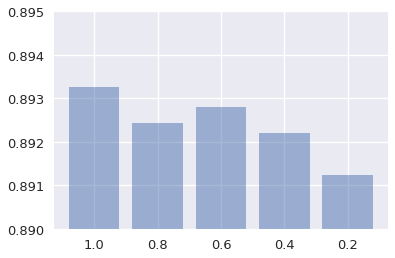

'\nThis graph shows the change in accuracy depending on the regularization value, or rather the inverse of regularization value.\nThe graph shows two modes, with the higher mode around 1.0.\n'

In [259]:
reg_nums = [1.0, 0.8, 0.6, 0.4, 0.2]
y_pos = np.arange(len(reg_nums))
regularization_scores = [LogisticRegression(C=x).fit(X_train, y_train).score(X_train, y_train) for x in reg_nums]

plt.bar(y_pos, regularization_scores, align='center', alpha=0.5)
plt.xticks(y_pos, reg_nums)
plt.ylim(0.89, 0.895)
plt.show()

"""
This graph shows the change in accuracy depending on the regularization value, or rather the inverse of regularization value.
The graph shows two modes, with the higher mode around 1.0.
"""

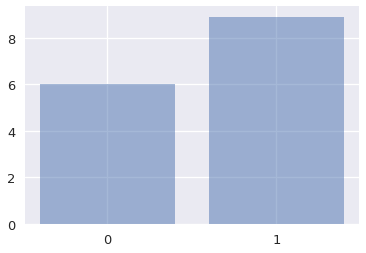

'\nThis graph shows that spam emails had an average of more than 8 "!" or "?" per email whereas ham emails had an average of around 6 "!" or "?" per email.\n'

In [268]:
spam_value = [0, 1]
y_pos = np.arange(len(spam_value))
avg_exc = [np.mean([len(re.findall(r"[!|?]", email)) for email in train[train["spam"] == i]["email"]]) for i in spam_value]

plt.bar(spam_value, avg_exc, align='center', alpha=0.5)
plt.xticks(y_pos, spam_value)
plt.show()

"""
This graph shows that spam emails had an average of more than 8 "!" or "?" per email whereas ham emails had an average of around 6 "!" or "?" per email.
"""

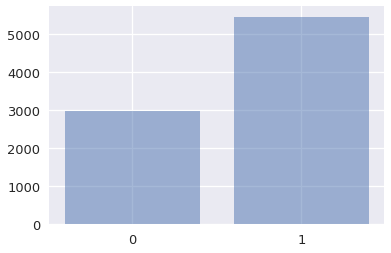

'\nThis bar plot shows that spam emails on average were more than 5000 characters long, whereas ham emails were about 3000\ncharacters long.\n'

In [271]:
avg_len = [np.mean([len(email) for email in train[train["spam"] == i]["email"]]) for i in spam_value]
plt.bar(spam_value, avg_len, align='center', alpha=0.5)
plt.xticks(y_pos, spam_value)
plt.show()
"""
This bar plot shows that spam emails on average were more than 5000 characters long, whereas ham emails were about 3000
characters long.
"""

'\nThis scatter plot shows a very steep increase in the number of exclamations and question marks as the spam emails increased in length.\nThis correlation is also found in ham emails, but to a much lesser degree.\n'

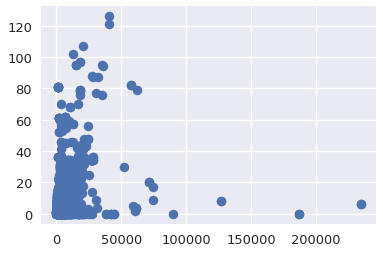

In [279]:
train[train["spam"] == 0]

#plt.scatter([len(email) for email in train[train["spam"] == 0]["email"]], [len(re.findall(r"[!|?]", email)) for email in train[train["spam"] == 0]["email"]])

plt.scatter([len(email) for email in train[train["spam"] == 1]["email"]], [len(re.findall(r"[!|?]", email)) for email in train[train["spam"] == 1]["email"]])

"""
This scatter plot shows a very steep increase in the number of exclamations and question marks as the spam emails increased in length.
This correlation is also found in ham emails, but to a much lesser degree.
"""

### Making an ROC Curve

It turns out that there's a tradeoff between sensitivity and specificity. In most cases we won't be able to get perfect sensitivity and specificity, so we have to select which of two we value more. For example, in the case of cancer screenings we value specificity more because false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it >=0.5 probability of being spam. However, we can adjust that cutoff: we can say that an email is spam only if our classifier gives it >=0.7 probability of being spam, for example. This is how we can trade off sensitivity and specificity.

The ROC (receiver operating charactistic) curve shows this trade off for each possible cutoff probability. We will discuss this during lecture, and you can also read [this blog post for more information.](https://www.theanalysisfactor.com/what-is-an-roc-curve/).

In the light blue cell below, plot the ROC curve for your final classifier (the one you use to make predictions for Kaggle).

Text(0,0.5,'True Positive Rate')

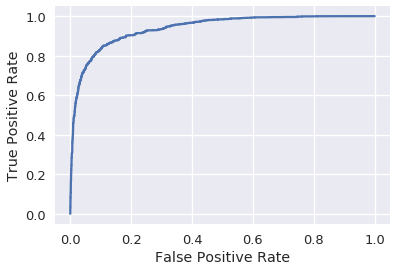

In [287]:
from sklearn.metrics import roc_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

fpr, tpr, thresholds = roc_curve(y_train, [x[1] for x in clf.predict_proba(X_train)])

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

The code below assumes that you've saved your predictions in a 1-dimensional array called `test_predictions`.

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/t/433a6bca95f94a78a0d2a6e7e8b311c3

In [237]:
X_test = words_in_texts(emailwordbag, test["email"])
for i in np.arange(len(X_test)):
    X_test[i] += words_in_text(subjectwordbag, str(test["subject"][i]))
    X_test[i] += [len(re.findall(r"[!|?]", test["email"][i]))]
    X_test[i] += [len(re.findall(r"you", test["email"][i]))]
    X_test[i] += [len(re.findall(r"[!|?|%]", str(test["subject"][i])))]
    X_test[i] += [len(re.findall(r"[$|\d]", str(test["subject"][i])))]
    X_test[i] += [len(re.findall(r"[A-Z]", str(test["subject"][i])))]
    X_test[i] += [len(re.findall(r"\[.*?\]", str(test["subject"][i])))]
test_predictions = clf.predict(X_test)


In [238]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.
assert isinstance(test_predictions, np.ndarray)
assert test_predictions.shape == (1000, )

submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])

timestamp = datetime.isoformat(datetime.now()).split(".")[0]

submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)
print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2017-12-12T01:21:28.csv.
You may now upload this CSV file to Kaggle for scoring.


## Submission

Run the cell below to submit your notebook to OkPy:

In [289]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj2.ipynb'.
Submit... 0.0% complete
Could not submit: Late Submission of cal/ds100/fa17/proj2
Backup... 100% complete



Now, run this cell to create a PDF to upload to Gradescope.

In [290]:
!pip install -U gs100
from gs100 import convert
# Change the zoom argument if your font size is too small
convert('proj2.ipynb', num_questions=8, zoom=1)

Requirement already up-to-date: PyPDF2>=1.26 in /home/ksab77/anaconda3/envs/ds100/lib/python3.6/site-packages (from gs100)
Requirement already up-to-date: nbconvert>=5 in /home/ksab77/anaconda3/envs/ds100/lib/python3.6/site-packages (from gs100)
Requirement already up-to-date: beautifulsoup4>=4 in /home/ksab77/anaconda3/envs/ds100/lib/python3.6/site-packages (from gs100)
Requirement already up-to-date: pdfkit>=0.6 in /home/ksab77/anaconda3/envs/ds100/lib/python3.6/site-packages (from gs100)
Requirement already up-to-date: toolz>=0.8 in /home/ksab77/anaconda3/envs/ds100/lib/python3.6/site-packages (from gs100)
Requirement already up-to-date: nbformat>=4 in /home/ksab77/anaconda3/envs/ds100/lib/python3.6/site-packages (from gs100)
Requirement already up-to-date: jinja2 in /home/ksab77/anaconda3/envs/ds100/lib/python3.6/site-packages (from nbconvert>=5->gs100)
Requirement already up-to-date: pygments in /home/ksab77/anaconda3/envs/ds100/lib/python3.6/site-packages (from nbconvert>=5->gs10

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj2.ipynb'.
Created question_pdfs/q_email.pdf
Created question_pdfs/q01.pdf
Created question_pdfs/q06.pdf
Created question_pdfs/q_feature.pdf
Created question_pdfs/q_eda1.pdf
Created question_pdfs/q_eda2.pdf
Created question_pdfs/q_eda3.pdf
Created question_pdfs/q_eda4.pdf
Created question_pdfs/q_roc.pdf


If the font size of your PDF is too small/large, change the value of the zoom argument when calling convert. For example, setting zoom=2 makes everything twice as big.


Make sure to upload your PDF now. Otherwise, your written questions won't be graded.